In [248]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
from datetime import datetime

In [249]:
#Data import and exploration
data = pd.read_csv("dataset_Path/Newone.csv")

#Remove unnecessary columns
data.drop(columns=['Unnamed: 6','Unnamed: 7','Unnamed: 8','Unnamed: 9'], inplace=True)

#displa dataset information
print("Dataset length: ", len(data))
print("Dataset shape: ", data.shape)
print("Dataset: ", data.head())

data

Dataset length:  149
Dataset shape:  (149, 6)
Dataset:         Date  Time (24h)  Humidity(%) Weather  Temperature (C)   \
0  08-02-23          17        78.25   Sunny              27.0   
1  08-02-23          17        79.34   Sunny              28.6   
2  08-02-23           9        71.81   Sunny              29.1   
3  08-02-23          11        68.31   Windy              29.8   
4  08-05-23          10        68.72  Cloudy              29.3   

              Location  
0  6.867831, 79.967030  
1  6.867818, 79.967296  
2  6.867831, 79.967030  
3  6.867831, 79.967030  
4  6.867451, 79.967261  


,Date,Time (24h),Humidity(%),Weather,Temperature (C),Location
0,08-02-23,17,78.25,Sunny,27.0,"6.867831, 79.967030"
1,08-02-23,17,79.34,Sunny,28.6,"6.867818, 79.967296"
2,08-02-23,9,71.81,Sunny,29.1,"6.867831, 79.967030"
3,08-02-23,11,68.31,Windy,29.8,"6.867831, 79.967030"
4,08-05-23,10,68.72,Cloudy,29.3,"6.867451, 79.967261"
...,...,...,...,...,...,...
144,28-08-23,11,70.24,Rainy,31.1,"6.867818, 79.967296"
145,08-02-23,11,59.38,Sunny,29.0,"6.867818, 79.967501"
146,08-11-23,18,81.41,Cloudy,27.8,"6.867818, 79.967501"
147,20-08-23,10,62.17,Sunny,30.9,"6.867818, 79.967296"


In [250]:
#Change the "Weather" column values into numerical values
weather_mapping = {'Sunny': 0, 'Cloudy':1, 'Rainy': 2, 'Windy': 3}

#Replace values in the Weather column
data['Weather'] = data['Weather'].replace(weather_mapping)

# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%y')

In [251]:
# Convert 'Date' to datetime format
data['Time (24h)'] = pd.to_datetime(data['Time (24h)'], format='%H')

# Extract time part from 'Time (24h)' column
time_part = data['Time (24h)'].dt.time

# Combine 'Date' column and time_part
merged_datetime = data['Date'] + pd.to_timedelta(time_part.astype(str))

# Assign the merged datetime to a new column
data['Datetime'] = merged_datetime

# Drop the individual 'Date' and 'Time (24h)' columns if needed
data.drop(columns=['Date', 'Time (24h)'], inplace=True)

# Set 'Datetime' column as the index
#data.set_index('Datetime', inplace=True)

data

,Humidity(%),Weather,Temperature (C),Location,Datetime
0,78.25,0,27.0,"6.867831, 79.967030",2023-02-08 17:00:00
1,79.34,0,28.6,"6.867818, 79.967296",2023-02-08 17:00:00
2,71.81,0,29.1,"6.867831, 79.967030",2023-02-08 09:00:00
3,68.31,3,29.8,"6.867831, 79.967030",2023-02-08 11:00:00
4,68.72,1,29.3,"6.867451, 79.967261",2023-05-08 10:00:00
...,...,...,...,...,...
144,70.24,2,31.1,"6.867818, 79.967296",2023-08-28 11:00:00
145,59.38,0,29.0,"6.867818, 79.967501",2023-02-08 11:00:00
146,81.41,1,27.8,"6.867818, 79.967501",2023-11-08 18:00:00
147,62.17,0,30.9,"6.867818, 79.967296",2023-08-20 10:00:00


In [252]:
print(data.columns)

Index(['Humidity(%)', 'Weather', 'Temperature (C) ', 'Location', 'Datetime'], dtype='object')


In [253]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Humidity(%)       149 non-null    float64       
 1   Weather           149 non-null    int64         
 2   Temperature (C)   149 non-null    float64       
 3   Location          149 non-null    object        
 4   Datetime          149 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 5.9+ KB


In [254]:
# Preprocessing
# Convert 'Datetime' to numerical value
data['Datetime'] = pd.to_datetime(data['Datetime'])
data['Datetime'] = data['Datetime'].apply(lambda x: x.timestamp())

# Remove the percentage sign and convert 'Humidity%' to numerical value
data['Humidity(%)'] = data['Humidity(%)'].astype(float)

data['Weather'] = data['Weather'].astype(float)

# Scale the numerical features
scaler = StandardScaler()
data[['Humidity(%)', 'Temperature (C) ', 'Datetime']] = scaler.fit_transform(data[['Humidity(%)', 'Temperature (C) ', 'Datetime']])

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Location' column
data['Location'] = label_encoder.fit_transform(data['Location'])

# Print the mapping of original labels to encoded labels
#print("Label Mapping:")
#for label, encoded_label in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
  #  print(f"{label} : {encoded_label}")

In [255]:
data['Location'] = data['Location'].astype(float)

In [256]:
data

,Humidity(%),Weather,Temperature (C),Location,Datetime
0,1.224447,0.0,-2.689830,5.0,-1.832440
1,1.397968,0.0,-0.924745,3.0,-1.832440
2,0.199238,0.0,-0.373156,5.0,-1.836296
3,-0.357941,3.0,0.399069,5.0,-1.835332
4,-0.292671,1.0,-0.152520,0.0,-0.806279
...,...,...,...,...,...
144,-0.050696,2.0,1.833201,3.0,0.489798
145,-1.779542,0.0,-0.483473,4.0,-1.835332
146,1.727500,1.0,-1.807288,4.0,1.326054
147,-1.335391,0.0,1.612566,3.0,0.396773


In [257]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Humidity(%)       149 non-null    float64
 1   Weather           149 non-null    float64
 2   Temperature (C)   149 non-null    float64
 3   Location          149 non-null    float64
 4   Datetime          149 non-null    float64
dtypes: float64(5)
memory usage: 5.9 KB


In [258]:
# Splitting into input and output
X = data[['Humidity(%)', 'Weather', 'Temperature (C) ', 'Datetime']].values
y = data['Location'].values

In [259]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [260]:
# Reshape the input data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [261]:
X_train.shape

(119, 1, 4)

In [262]:
X_test.shape

(30, 1, 4)

In [263]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [296]:
# Define the RNN model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' activation for binary classification

In [297]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  # Use 'binary_crossentropy' for binary classification

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=24, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

Epoch 1/25
5/5 [==============================] - 5s 203ms/step - loss: 0.6240 - accuracy: 0.0504 - val_loss: 0.5620 - val_accuracy: 0.0667
Epoch 2/25
5/5 [==============================] - 0s 15ms/step - loss: 0.5663 - accuracy: 0.0588 - val_loss: 0.4908 - val_accuracy: 0.0667
Epoch 3/25
5/5 [==============================] - 0s 13ms/step - loss: 0.5049 - accuracy: 0.0588 - val_loss: 0.4163 - val_accuracy: 0.0667
Epoch 4/25
5/5 [==============================] - 0s 12ms/step - loss: 0.4453 - accuracy: 0.0504 - val_loss: 0.3410 - val_accuracy: 0.0667
Epoch 5/25
5/5 [==============================] - 0s 12ms/step - loss: 0.3826 - accuracy: 0.0504 - val_loss: 0.2648 - val_accuracy: 0.0667
Epoch 6/25
5/5 [==============================] - 0s 11ms/step - loss: 0.3209 - accuracy: 0.0420 - val_loss: 0.1846 - val_accuracy: 0.0667
Epoch 7/25
5/5 [==============================] - 0s 11ms/step - loss: 0.2552 - accuracy: 0.0420 - val_loss: 0.1015 - val_accuracy: 0.0667
Epoch 8/25
5/5 [==========

In [298]:
# Evaluate the model
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 6.67


In [299]:
from sklearn.metrics import mean_squared_error
import math

# Make predictions on the test data
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.round(y_pred_prob).astype(int)

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', rmse)

1/1 [==============================] - 0s 497ms/step
Root Mean Squared Error (RMSE): 2.1984843263788196


In [300]:
# Save the trained model
model.save("rnn_model.h5")

D:\Software\Anaconda\Software\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


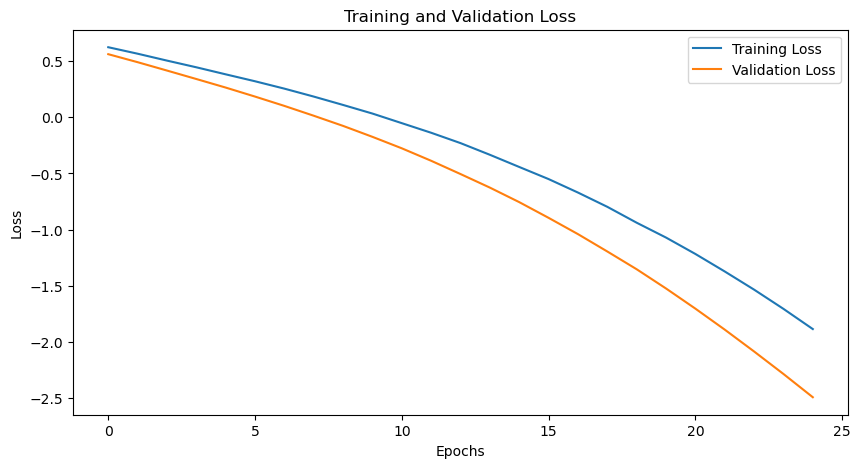

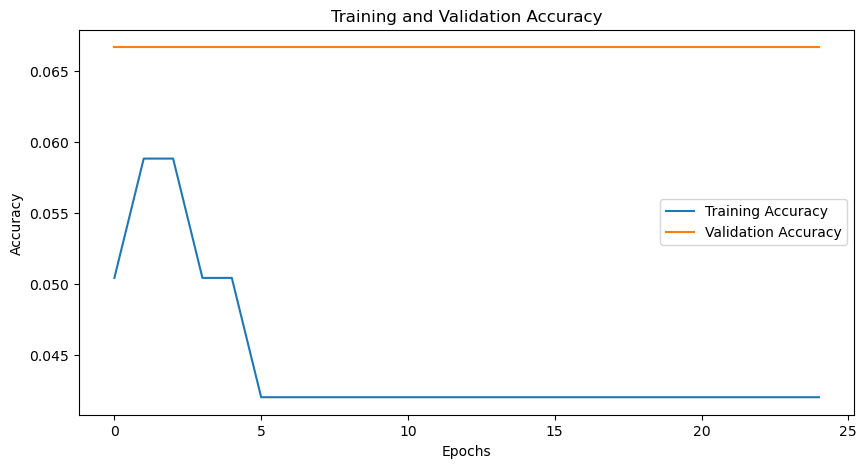

In [301]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1/1 [==============================] - 0s 21ms/step


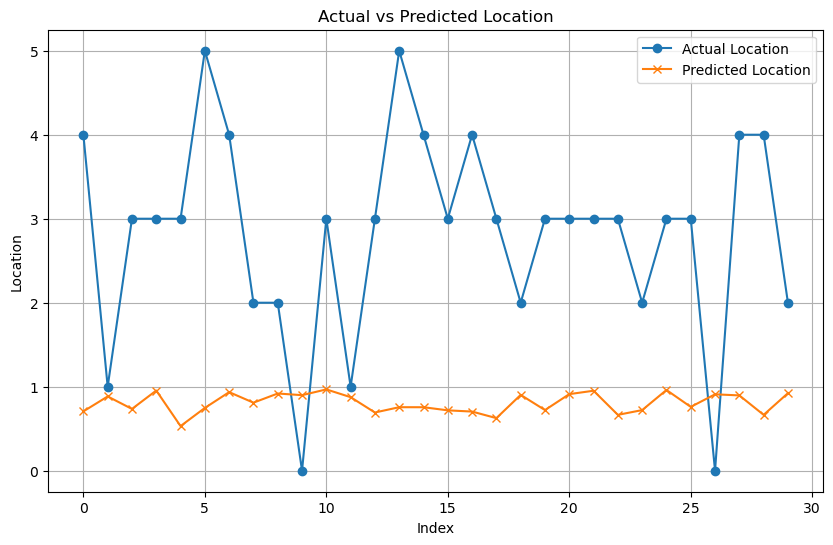

In [302]:
import matplotlib.pyplot as plt

# Predict locations using the trained model
y_pred = model.predict(X_test)

# Plot actual vs predicted locations
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Location', marker='o')
plt.plot(y_pred, label='Predicted Location', marker='x')
plt.title('Actual vs Predicted Location')
plt.xlabel('Index')
plt.ylabel('Location')
plt.legend()
plt.grid(True)
plt.show()

In [273]:
import numpy as np
from keras.models import load_model
from sklearn.preprocessing import StandardScaler
from datetime import datetime

# Load the trained model
model = load_model("rnn_model.h5")

###################################################################

# Load the scaler used for preprocessing
scaler = StandardScaler()
scaler.mean_ = np.array([68.131208, 1.457048, 26.176510, 1631788596.9119325])
scaler.scale_ = np.array([20.166091, 1.075945, 2.178171, 766633.174204762])

# Function to preprocess user input and make predictions
def predict_location(datetime_input, temperature, humidity):
    # Convert datetime to timestamp
    timestamp = datetime_input.timestamp()
    
    # Scale the input features
    scaled_features = scaler.transform([[humidity, 0, temperature, timestamp]])
    
    # Reshape the input data for LSTM
    input_data = np.reshape(scaled_features, (scaled_features.shape[0], 1, scaled_features.shape[1]))
    
    # Make predictions
    prediction = model.predict(input_data)
    
    return prediction

####################################################################

# Take user input for datetime
datetime_input_str = input("Enter datetime (YYYY-MM-DD HH:MM:SS): ")
datetime_input = datetime.strptime(datetime_input_str, "%Y-%m-%d %H:%M:%S")

# Take user input for temperature
temperature_input = float(input("Enter temperature (in Celsius): "))

# Take user input for humidity
humidity_input = float(input("Enter humidity (%): "))

#####################################################################

# Predict location
prediction = predict_location(datetime_input, temperature_input, humidity_input)

# Convert the prediction numpy array to a single integer value
predicted_location = int(np.round(prediction[0]))

# Map the predicted location to corresponding coordinates
location_mapping = {
    1: "6.867831, 79.967030",
    2: "6.867818, 79.967296",
    3: "6.867818, 79.967501",
    4: "6.867690, 79.967585",
    5: "6.867536, 79.967425",
    6: "6.867451, 79.967261",
    7: "6.867603, 79.967033"
}

# Convert predicted location to corresponding coordinates
predicted_coordinates = location_mapping.get(predicted_location, "No location detected")

print("Predicted Location:", predicted_coordinates)


Enter datetime (YYYY-MM-DD HH:MM:SS): 2024-04-27 08:00:00
Enter temperature (in Celsius): 29
Enter humidity (%): 79
1/1 [==============================] - 1s 505ms/step
Predicted Location: 6.867831, 79.967030
